In [1]:
# Importing libraries
import sys
import pathlib
import warnings
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from scipy import signal
import scipy.io
from scipy import ndimage
import math
from skimage.morphology import area_closing
from skimage.morphology import binary_dilation
#skimage.morphology.area_closing
warnings.filterwarnings("ignore")

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')

In [4]:
# Path to images and masks

time_point = '5h' # 'wo' '18min', '5h'

if time_point == 'wo':
    data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')
    path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim/masks_MS2-CY5_Cyto543_560_woStim___nuc_70__cyto_0.zip') 
    name_merged_mask_tensors = 'polygons_wo'

if time_point == '18min':
    data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM')
    path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_18minTPL_5uM/masks_MS2-CY5_Cyto543_560_18minTPL_5uM___nuc_70__cyto_0.zip') 
    name_merged_mask_tensors = 'polygons_18min'
    
if time_point == '5h':
    data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM')
    path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM/masks_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_70__cyto_0.zip') 
    name_merged_mask_tensors = 'polygons_5h'
    

In [5]:
download_data_from_NAS = True
send_data_to_NAS = False

In [6]:
%%capture
# Download data from NAS
local_data_dir, masks_dir, _, _, list_files_names = fa.Utilities.read_images_from_folder( path_to_config_file, data_folder_path, path_to_masks_dir,  download_data_from_NAS)


In [7]:
local_data_dir

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks/temp_MS2-CY5_Cyto543_560_5hTPL_5uM/merged')

In [8]:
masks_dir

PosixPath('/home/luisub/Desktop/FISH_Processing/notebooks/masks_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_70__cyto_0')

In [9]:
list_files_names

['ROI001_XY1657822809_Z00_T0_merged.tif',
 'ROI002_XY1657822933_Z00_T0_merged.tif',
 'ROI003_XY1657822934_Z00_T0_merged.tif',
 'ROI005_XY1657822936_Z00_T0_merged.tif',
 'ROI006_XY1657822937_Z00_T0_merged.tif',
 'ROI007_XY1657822938_Z00_T0_merged.tif',
 'ROI008_XY1657822939_Z00_T0_merged.tif',
 'ROI010_XY1657822941_Z00_T0_merged.tif',
 'ROI013_XY1657822944_Z00_T0_merged.tif',
 'ROI014_XY1657822945_Z00_T0_merged.tif',
 'ROI015_XY1657822946_Z00_T0_merged.tif',
 'ROI016_XY1657822947_Z00_T0_merged.tif',
 'ROI017_XY1657822948_Z00_T0_merged.tif',
 'ROI018_XY1657822949_Z00_T0_merged.tif']

In [10]:
# Path to read each file with masks.
NUM_POINTS_MASK_EDGE_LINE = 200
list_center_mass = []
list_complete_masks =[]
list_masks = []
for file_id , temp_file_name in enumerate (list_files_names):
    mask_nuc_path = masks_dir.absolute().joinpath('masks_nuclei_' + temp_file_name  )
    masks_nuclei = imread(str(mask_nuc_path ))
    list_complete_masks.append(masks_nuclei)
    # iterate for each mask
    n_masks =np.max(masks_nuclei)  
    tensor_masks = np.zeros((n_masks,NUM_POINTS_MASK_EDGE_LINE,2))               
    for i in range(1, n_masks+1 ):
        # Removing the borders just for plotting
        tested_mask_nuc = np.where(masks_nuclei == i, 1, 0).astype(bool)
        list_masks.append(tested_mask_nuc)
        # removing pixels outside the main mask
        centroid_y,centroid_x = ndimage.measurements.center_of_mass(tested_mask_nuc)
        list_center_mass.append((centroid_y,centroid_x ))
        # Remove border for plotting
        temp_contour_n = find_contours(tested_mask_nuc, 0.5, fully_connected='high',positive_orientation='high')
        contour_n = np.asarray(temp_contour_n[0])
        # Downsample the array using signal.resample
        downsampled_mask = signal.resample(contour_n, num = NUM_POINTS_MASK_EDGE_LINE)
        tensor_masks[i-1,:,:] = downsampled_mask
    # Concatenate mask tensor.
    if file_id ==0:
        merged_mask_tensors = tensor_masks
    if file_id >0:
        merged_mask_tensors = np.concatenate((merged_mask_tensors, tensor_masks), axis=0)
    del tensor_masks,masks_nuclei


In [11]:
NUM_COLUMNS = 10
number_cells = merged_mask_tensors.shape[0]
NUM_ROWS = math.ceil(number_cells/ NUM_COLUMNS)

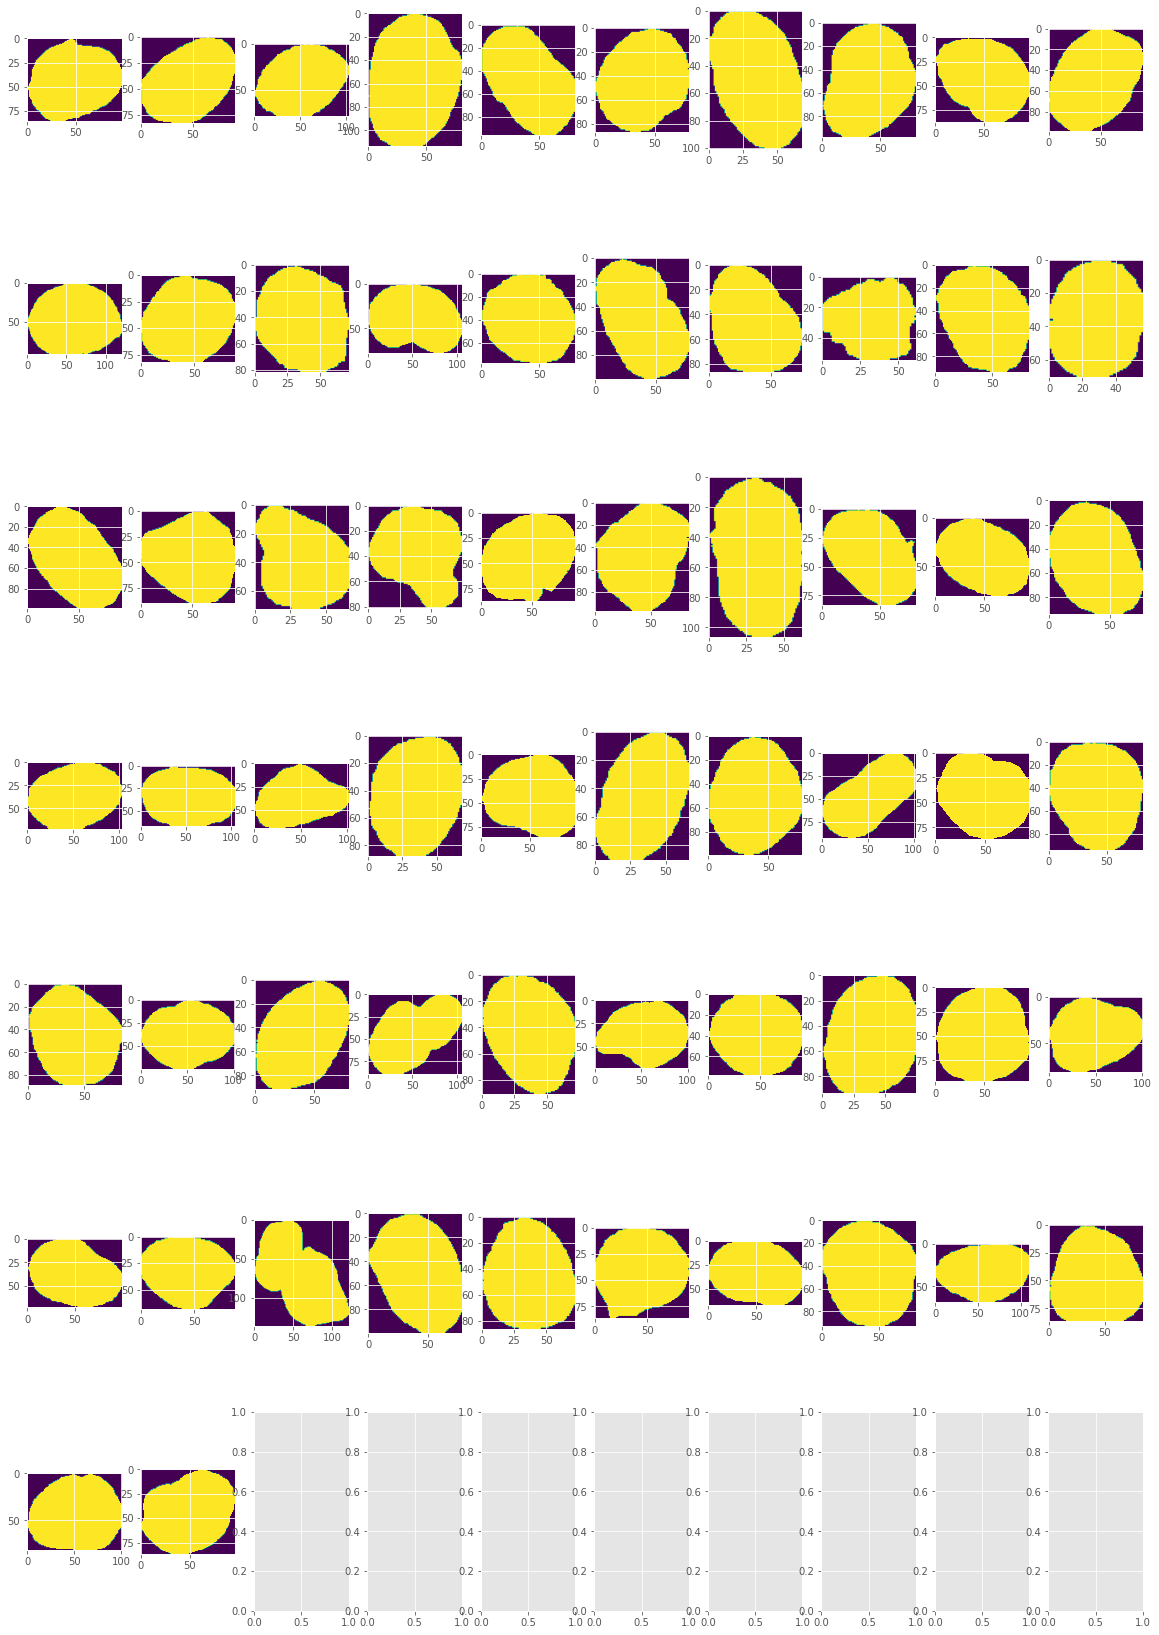

In [12]:
# plotting maks as contours.
_, axes = plt.subplots(nrows = NUM_ROWS, ncols = NUM_COLUMNS, figsize = (20, 30))
r = 0
c = 0
counter = 0
for i in range(0, number_cells):
    
    min_x = np.max( (0, np.min(merged_mask_tensors[i,:, 1]))).astype(int)
    max_x = np.max(merged_mask_tensors[i,:, 1]).astype(int)

    min_y = np.max( (0, np.min(merged_mask_tensors[i,:, 0]))).astype(int)
    max_y = np.max(merged_mask_tensors[i,:, 0]).astype(int)
    
    axes[r,c].imshow(list_masks[i][ min_y:max_y, min_x:max_x ])
    
    c+=1
    if (c>0) and (c%10 ==0):
        c=0
        r+=1
    counter +=1
plt.savefig('masks_'+name_merged_mask_tensors+'.pdf', transparent=False,dpi=1200, bbox_inches = 'tight', format='pdf')
plt.show()


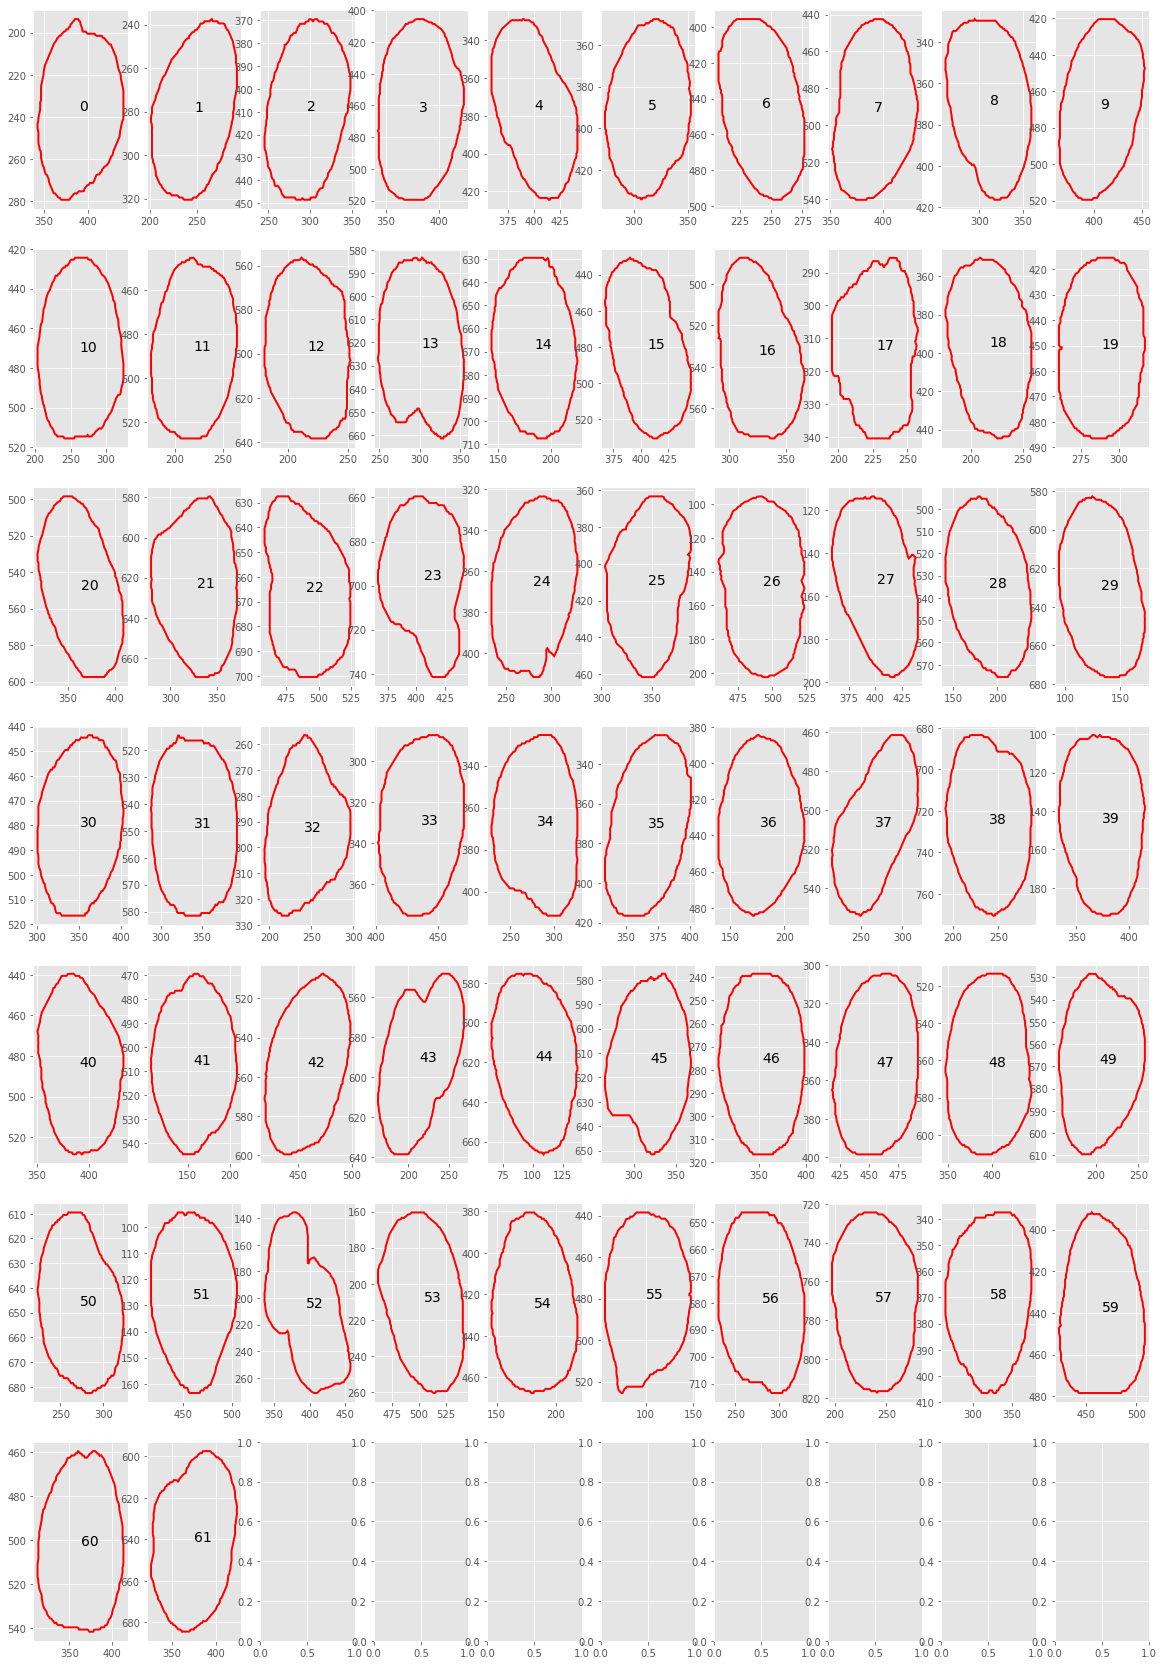

In [13]:
# plotting maks as contours.
_, axes = plt.subplots(nrows = NUM_ROWS, ncols = NUM_COLUMNS, figsize = (20, 30))
r = 0
c = 0
counter = 0
for i in range(0, number_cells):
    axes[r,c].fill(merged_mask_tensors[i,:, 1], merged_mask_tensors[i,:, 0], facecolor = 'none', edgecolor = 'red', linewidth=2) # mask nucleus
    axes[r,c].text(x=list_center_mass[counter][1],y=list_center_mass[counter][0],s=str(counter), fontsize=14)
    axes[r,c].invert_yaxis()
    c+=1
    if (c>0) and (c%10 ==0):
        c=0
        r+=1
    counter +=1
plt.savefig(name_merged_mask_tensors+'.pdf', transparent=False,dpi=1200, bbox_inches = 'tight', format='pdf')
plt.show()


In [14]:
# Saving masks as matlab arrays
mask_dic = {name_merged_mask_tensors: merged_mask_tensors}
scipy.io.savemat(name_merged_mask_tensors+'.mat', mask_dic)